In [ ]:
import time
import torch
import matplotlib.pyplot as plt

from ase import Atoms
from batch_nl import NeighbourList

from vesin import ase_neighbor_list as vesin_ase_neighbor_list
from matscipy.neighbours import neighbour_list as matscipy_neighbour_list
from torch_nl import compute_neighborlist, ase2data
from nvalchemiops.neighborlist import neighbor_list

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'lines.markersize': 4,
    'lines.linewidth': 1.5,  # Increased from 1 to 1.5
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 8,
    'axes.grid': True,
    'grid.linewidth': 0.5,
    'grid.alpha': 1.0,
})

colors = sns.color_palette("deep")

In [11]:
def time_fn(fn, n_tries=10, sync_cuda=False):
    """
    A simple function to time a function.
    """

    # warmup run

    fn()

    times = []

    for _ in range(n_tries):

        if sync_cuda and torch.cuda.is_available():
            torch.cuda.synchronize()
        
        start = time.perf_counter()

        fn()

        if sync_cuda and torch.cuda.is_available():
            torch.cuda.synchronize()

        end = time.perf_counter()

        times.append((end - start) * 1000.0)  # ms

    if n_tries == 1:
        return times[0], 0.0

    mean_ms = sum(times) / n_tries

    # sample variance (no math)
    var = sum((t - mean_ms)**2 for t in times) / (n_tries - 1)

    # std and stderr via **0.5 instead of math.sqrt
    std_ms = var ** 0.5
    stderr_ms = std_ms / ((n_tries) ** 0.5)

    return mean_ms, stderr_ms

In [12]:
cell = [
    [2.460394, 0.0, 0.0],
    [-1.26336, 2.044166, 0.0],
    [-0.139209, -0.407369, 6.809714],
]

positions = [
    [-0.03480225, -0.10184225, 1.70242850],
    [-0.10440675, -0.30552675, 5.10728550],
    [-0.05691216,  1.26093576, 1.70242850],
    [ 1.11473716,  0.37586124, 5.10728550],
]

base = Atoms(
    symbols="CCCC",
    positions=positions,
    cell=cell,
    pbc=True,
)

In [6]:

supercells = [1, 2, 4, 6, 8, 10]      # (n,n,n) replication
radii = [3.0, 4.5, 6.0]
n_tries = 2

device = "cuda:1" 

In [7]:
results = {}   # radius → num_atoms → timings dict

# compiled batch_nl variants
compile_variants = [
    (torch.float64, "batch_nl_on2_f64"),
    (torch.float32, "batch_nl_on2_f32"),
]

for radius in radii:
    print("\n" + "=" * 80)
    print(f"radius = {radius}")
    print("=" * 80)

    res_r = results[radius] = {}

    for n in supercells:
        carbon = base * (n, n, n)
        num_atoms = len(carbon)
        print(f"\nSupercell size: ({n}, {n}, {n})  →  num_atoms = {num_atoms}")

        res_n = res_r[num_atoms] = {}

        # batch_nl ON2 (no compile, f64)
        nl = NeighbourList(
            list_of_positions=[carbon.positions],
            list_of_cells=[carbon.cell.array],
            cutoff=radius,
            float_dtype=torch.float64,
            device=device,
        )
        nl.load_data()

        t, e = time_fn(
            lambda: nl.calculate_neighbourlist(use_torch_compile=False),
            n_tries=n_tries,
            sync_cuda=True,
        )
        res_n["batch_nl_on2_no_compile_f64"] = {"mean": t, "stderr": e}

        # batch_nl ON2 (compile, f64 / f32)
        for float_dtype, key in compile_variants:
            nl_comp = NeighbourList(
                list_of_positions=[carbon.positions],
                list_of_cells=[carbon.cell.array],
                cutoff=radius,
                float_dtype=float_dtype,
                device=device,
            )
            nl_comp.load_data()

            t, e = time_fn(
                lambda: nl_comp.calculate_neighbourlist(use_torch_compile=True),
                n_tries=n_tries,
                sync_cuda=True,
            )
            res_n[key] = {"mean": t, "stderr": e}

        # VESIN O(N)
        t, e = time_fn(
            lambda: vesin_ase_neighbor_list("ijSDd", carbon, cutoff=radius),
            n_tries=n_tries,
            sync_cuda=False,
        )
        res_n["vesin_on1"] = {"mean": t, "stderr": e}

        # matscipy O(N)
        t, e = time_fn(
            lambda: matscipy_neighbour_list("ijSDd", carbon, cutoff=radius),
            n_tries=n_tries,
            sync_cuda=False,
        )
        res_n["matscipy_on1"] = {"mean": t, "stderr": e}

        # shared batched data for torch-nl and NVIDIA (single config)
        pos, cell_t, pbc, batch_idx, _ = ase2data([carbon])
        cells = cell_t.contiguous().view(-1, 3, 3)  # (1, 3, 3)

        # torch-nl O(N)
        t, e = time_fn(
            lambda: compute_neighborlist(radius, pos, cell_t, pbc, batch_idx, False),
            n_tries=n_tries,
            sync_cuda=True,
        )
        res_n["torch_on1"] = {"mean": t, "stderr": e}

        # NVIDIA ALCHEMI O(N)
        t, e = time_fn(
            lambda: neighbor_list(
                pos,
                radius,
                cell=cells,
                pbc=pbc,
                batch_idx=batch_idx,
                method="batch_cell_list",
            ),
            n_tries=n_tries,
            sync_cuda=True,
        )
        res_n["nvidia_on1"] = {"mean": t, "stderr": e}

        # summary
        print(
            f"  batch_nl ON2 O(N^2) no-compile (f64) : "
            f"{res_n['batch_nl_on2_no_compile_f64']['mean']:8.3f} ± "
            f"{res_n['batch_nl_on2_no_compile_f64']['stderr']:5.3f} ms"
        )

        for _, key in compile_variants:
            pretty = "f64" if key.endswith("f64") else "f32"
            t = res_n[key]["mean"]
            e = res_n[key]["stderr"]
            print(
                f"  batch_nl ON2 O(N^2) compile ({pretty})    : "
                f"{t:8.3f} ± {e:5.3f} ms"
            )

        print(
            f"  VESIN O(N)                              : "
            f"{res_n['vesin_on1']['mean']:8.3f} ± {res_n['vesin_on1']['stderr']:5.3f} ms"
        )
        print(
            f"  matscipy O(N)                           : "
            f"{res_n['matscipy_on1']['mean']:8.3f} ± {res_n['matscipy_on1']['stderr']:5.3f} ms"
        )
        print(
            f"  torch-nl O(N)                           : "
            f"{res_n['torch_on1']['mean']:8.3f} ± {res_n['torch_on1']['stderr']:5.3f} ms"
        )
        print(
            f"  NVIDIA O(N) (batch_cell)                : "
            f"{res_n['nvidia_on1']['mean']:8.3f} ± {res_n['nvidia_on1']['stderr']:5.3f} ms"
        )



radius = 3.0

Supercell size: (1, 1, 1)  →  num_atoms = 4


/home/vkapil/anaconda3/lib/python3.12/site-packages/batch_nl/neighbourlist.py:140: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  self.batch_cell_tensor = torch.tensor(
/home/vkapil/anaconda3/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


  batch_nl ON2 O(N^2) no-compile (f64) :    1.175 ± 0.355 ms
  batch_nl ON2 O(N^2) compile (f64)    :    0.978 ± 0.193 ms
  batch_nl ON2 O(N^2) compile (f32)    :    1.061 ± 0.223 ms
  VESIN O(N)                              :    0.053 ± 0.010 ms
  matscipy O(N)                           :    0.029 ± 0.004 ms
  torch-nl O(N)                           :    9.145 ± 8.253 ms
  NVIDIA O(N) (batch_cell)                :    0.410 ± 0.025 ms

Supercell size: (2, 2, 2)  →  num_atoms = 32
  batch_nl ON2 O(N^2) no-compile (f64) :    0.790 ± 0.039 ms
  batch_nl ON2 O(N^2) compile (f64)    :    1.012 ± 0.199 ms
  batch_nl ON2 O(N^2) compile (f32)    :    1.005 ± 0.187 ms
  VESIN O(N)                              :    0.102 ± 0.010 ms
  matscipy O(N)                           :    0.127 ± 0.003 ms
  torch-nl O(N)                           :    1.679 ± 0.180 ms
  NVIDIA O(N) (batch_cell)                :    0.551 ± 0.016 ms

Supercell size: (4, 4, 4)  →  num_atoms = 256
  batch_nl ON2 O(N^2) no-comp

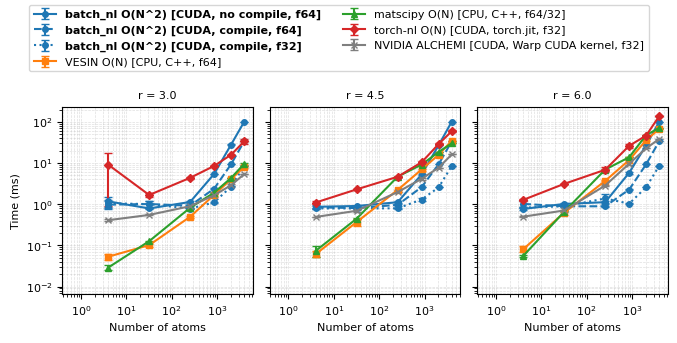

In [13]:
methods = [
    "batch_nl_on2_no_compile_f64",
    "batch_nl_on2_f64",
    "batch_nl_on2_f32",
    "vesin_on1",
    "matscipy_on1",
    "torch_on1",
    "nvidia_on1",
]

labels = {
    "batch_nl_on2_no_compile_f64": "batch_nl O(N^2) [CUDA, no compile, f64]",
    "batch_nl_on2_f64":            "batch_nl O(N^2) [CUDA, compile, f64]",
    "batch_nl_on2_f32":            "batch_nl O(N^2) [CUDA, compile, f32]",
    "vesin_on1":                   "VESIN O(N) [CPU, C++, f64]",
    "matscipy_on1":                "matscipy O(N) [CPU, C++, f64/32]",
    "torch_on1":                   "torch-nl O(N) [CUDA, torch.jit, f32]",
    "nvidia_on1":                  "NVIDIA ALCHEMI [CUDA, Warp CUDA kernel, f32]",
}

# Explicit style per method (same as previous benchmark)
styles = {
    # batch_nl variants (same color, different linestyles)
    "batch_nl_on2_no_compile_f64": dict(color="tab:blue", marker="o", linestyle="-"),
    "batch_nl_on2_f64":            dict(color="tab:blue", marker="o", linestyle="--"),
    "batch_nl_on2_f32":            dict(color="tab:blue", marker="o", linestyle=":"),
    # others
    "vesin_on1":                   dict(color="tab:orange", marker="s", linestyle="-"),
    "matscipy_on1":                dict(color="tab:green",  marker="^", linestyle="-"),
    "torch_on1":                   dict(color="tab:red",    marker="D", linestyle="-"),
    "nvidia_on1":                  dict(color="tab:grey",   marker="x", linestyle="-"),
}

radii_list = list(results.keys())
num_panels = len(radii_list)

fig, axes = plt.subplots(
    1,
    num_panels,
    sharex=True,
    sharey=True,
    figsize=(3.41 * 2, 3.41),
)

if num_panels == 1:
    axes = [axes]

for ax, radius in zip(axes, radii_list):

    # x-axis = number of atoms in the supercell
    num_atoms_list = sorted(results[radius].keys())

    for method in methods:
        means  = [results[radius][na][method]["mean"]   for na in num_atoms_list]
        errors = [results[radius][na][method]["stderr"] for na in num_atoms_list]

        style = styles[method]

        ax.errorbar(
            num_atoms_list,
            means,
            yerr=errors,
            capsize=3,
            label=labels[method],
            **style,
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"r = {radius}")
    ax.grid(True, which="both", ls="--", alpha=0.4)

for ax in axes:
    ax.set_xlabel("Number of atoms")
axes[0].set_ylabel("Time (ms)")

handles, legend_labels = axes[0].get_legend_handles_labels()

leg = fig.legend(
    handles,
    legend_labels,
    loc="upper center",
    ncol=2,
)

# bold only batch_nl entries
for text in leg.get_texts():
    label = text.get_text()
    if "batch_nl" in label:
        text.set_fontweight("bold")

plt.tight_layout(rect=[0, 0, 1, 0.78])
plt.show()
